# GARCH LSTM Forecasting

I will be making a GARCH-LSTM hybrid model to forecast S&P 500 returns using S&P 500 data and VIX downloaded from the yfinance package.

I will get both of these data from yahoo finance.

### Importing libraries and packages

In [1]:
import numpy as np
import pandas as pd

import yfinance

import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

from arch import arch_model

import plotly.express as px
import plotly.graph_objects as go

### Datasets

In [2]:
start_date = '2005-01-01'
end_date = '2025-01-01'

vix = yfinance.download('^VIX', start=start_date, end=end_date, interval='1d', auto_adjust=False)
vix.columns = ['Adj_Close', 'Close', 'High', 'Low', 'Open', 'Volume']
vix.drop(columns='Volume', inplace=True)
vix['log_returns'] = np.log(vix['Close']/vix['Close'].shift(1))
vix.dropna(inplace=True)
print(f"VIX Number of NA's: {vix.isna().sum().sum()}")
print(vix.head())

sp500 = yfinance.download('^GSPC', start=start_date, end=end_date, interval='1d', auto_adjust=False)
sp500.columns = ['Adj_Close', 'Close', 'High', 'Low', 'Open', 'Volume']
sp500.drop(columns='Volume', inplace=True)
sp500['log_returns'] = np.log(sp500['Close']/sp500['Close'].shift(1))
sp500.dropna(inplace=True)
sp500['Volatility'] = sp500['High']/sp500['Low'] - 1

print(f"SP500 Number of NA's: {sp500.isna().sum().sum()}")
print(sp500.head())


[*********************100%***********************]  1 of 1 completed


VIX Number of NA's: 0
            Adj_Close  Close   High    Low   Open  log_returns
Date                                                          
2005-01-04      13.98  13.98  14.45  13.93  14.01    -0.007128
2005-01-05      14.09  14.09  14.09  13.26  13.98     0.007838
2005-01-06      13.58  13.58  14.09  13.33  14.09    -0.036867
2005-01-07      13.49  13.49  13.51  12.94  13.47    -0.006649
2005-01-10      13.23  13.23  13.93  12.94  13.92    -0.019462


[*********************100%***********************]  1 of 1 completed

SP500 Number of NA's: 0
              Adj_Close        Close         High          Low         Open  \
Date                                                                          
2005-01-04  1188.050049  1188.050049  1205.839966  1185.390015  1202.079956   
2005-01-05  1183.739990  1183.739990  1192.729980  1183.719971  1188.050049   
2005-01-06  1187.890015  1187.890015  1191.630005  1183.270020  1183.739990   
2005-01-07  1186.189941  1186.189941  1192.199951  1182.160034  1187.890015   
2005-01-10  1190.250000  1190.250000  1194.780029  1184.800049  1186.189941   

            log_returns  Volatility  
Date                                 
2005-01-04    -0.011740    0.017252  
2005-01-05    -0.003634    0.007612  
2005-01-06     0.003500    0.007065  
2005-01-07    -0.001432    0.008493  
2005-01-10     0.003417    0.008423  


### Data Visualization

In [3]:
temp_Data = sp500.reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=temp_Data['Date'], y=temp_Data['log_returns'], name='log_returns', marker={'color':'red'}, mode='lines'))

fig.update_layout(title="SP500 log returns", xaxis_title='Date', yaxis_title='log returns')

fig.show()


### GARCH Model initialization

In [4]:
garch_model = arch_model(y=sp500['log_returns'], x=sp500, mean='Zero', vol='GARCH', p=1, q=1)

garch_result = garch_model.fit()

print("Fitting done!\n")

print(garch_result.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 2812479369.4380984
Iteration:      2,   Func. Count:     10,   Neg. LLF: -16452.322351287017
Optimization terminated successfully    (Exit mode 0)
            Current function value: -16452.322346143374
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Fitting done!

                       Zero Mean - GARCH Model Results                        
Dep. Variable:            log_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                16452.3
Distribution:                  Normal   AIC:                          -32898.6
Method:            Maximum Likelihood   BIC:                          -32879.1
                                        No. Observations:                 5032
Date:                Mon, Jul 28 2025   Df Residuals:                     50

c:\Users\danch\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001465. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




### GARCH model predictions

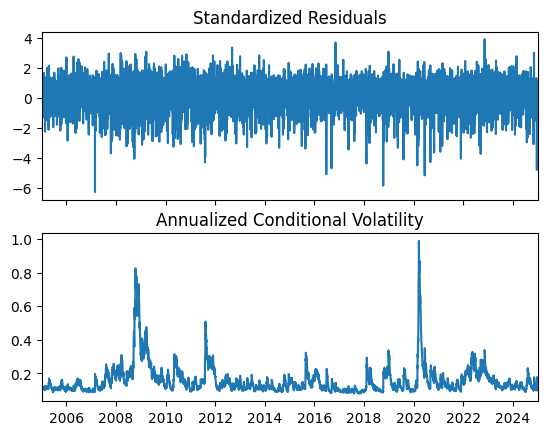

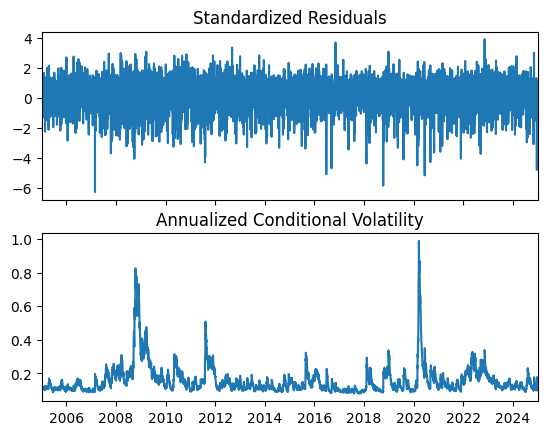

In [5]:
# garch_pred = garch_model.forecast(params=garch_result.params)

garch_result.plot(annualize='D')

In [6]:
print("Max standardized residual:", garch_result.std_resid.max())
print("Min standardized residual:", garch_result.std_resid.min())

from scipy.stats import kurtosis
print("Kurtosis of standardized residuals:", kurtosis(garch_result.std_resid))

Max standardized residual: 3.887600275995624
Min standardized residual: -6.2849421191219
Kurtosis of standardized residuals: 1.8375130061368043


In [7]:
forecast = garch_result.forecast(params=garch_result.params, horizon=10)
forecast.variance

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10
Date,,,,,,,,,,
2024-12-31,0.00009,0.00009,0.00009,0.00009,0.000089,0.000089,0.000089,0.000089,0.000089,0.000089


## LSTM model
Let's start with creating the sequenced data for our LSTM

In [33]:
garch_std_resid = garch_result.std_resid.values.reshape(-1, 1)
prices = vix['Close'].values.reshape(-1, 1)

print(garch_std_resid.shape)
print(prices.shape)


# Some reason the length is off by 1 T^T (5032 vs 5033), idk why
min_len = min(len(garch_std_resid), len(prices))
garch_std_resid = garch_std_resid[-min_len:]
prices = prices[-min_len:]

price_scaler = StandardScaler().fit(prices)
prices_norm = price_scaler.transform(prices)

features = np.concatenate([garch_std_resid, prices_norm], axis=1)


def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length, 1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LEN = 30
X, y = create_sequences(features, SEQ_LEN)

print("X shape:", X.shape)
print("y shape:", y.shape)

split = int(0.6 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)



class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = StockDataset(X_train, y_train)
test_ds = StockDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)


(5032, 1)
(5032, 1)
X shape: (5002, 30, 2)
y shape: (5002,)
(3001, 30, 2) (2001, 30, 2)
(3001,) (2001,)


In [34]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 1)
        # self.fc2 = nn.Linear(hidden_size // 2, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Take last timestep
        out = self.fc1(out)
        # out = self.fc2(out)
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

Training

In [35]:
EPOCHS = 50
train_losses = []
for epoch in range(1, EPOCHS+1):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        epoch_loss = epoch_loss + loss.item()*xb.size(0)
    
    avg_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    if epoch%5 == 0: print(f"Epoch {epoch}/{EPOCHS}, Training Loss: {avg_loss:.6f}")

c:\Users\danch\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning:

Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

c:\Users\danch\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning:

Using a target size (torch.Size([57])) that is different to the input size (torch.Size([57, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch 5/50, Training Loss: 0.497069
Epoch 10/50, Training Loss: 0.382015
Epoch 15/50, Training Loss: 0.356070
Epoch 20/50, Training Loss: 0.427681
Epoch 25/50, Training Loss: 0.342000
Epoch 30/50, Training Loss: 0.371170
Epoch 35/50, Training Loss: 0.332364
Epoch 40/50, Training Loss: 0.338296
Epoch 45/50, Training Loss: 0.325763
Epoch 50/50, Training Loss: 0.353519


In [36]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, EPOCHS+1)),
    y=train_losses,
    mode='lines+markers',
    name='Training Loss'
))
fig.update_layout(
    title='Training Loss',
    xaxis_title='Epoch',
    yaxis_title='Training Loss'
)
fig.show()

Eval

In [37]:
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    preds = model(X_test_tensor).cpu().numpy()

    preds_price = preds.reshape(-1, 1)
    y_test_price = y_test.reshape(-1, 1)
    preds_inv = price_scaler.inverse_transform(preds_price)
    y_test_inv = price_scaler.inverse_transform(y_test_price)

r2 = r2_score(y_test_inv, preds_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, preds_inv))
print(f"R^2: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

R^2: 0.8475
RMSE: 3.0432


In [39]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=np.arange(len(y_test_inv)),
    y=y_test_inv.flatten(),
    mode='lines',
    name='Actual Test Price'
))
fig.add_trace(go.Scatter(
    x=np.arange(len(preds_inv)),
    y=preds_inv.flatten(),
    mode='lines',
    name='Predicted Test Price'
))
fig.update_layout(
    title="LSTM Test Predictions vs Actual Test VIX Closed Price",
    xaxis_title="Test Time Step",
    yaxis_title="VIX Close Price",
    width=1500,
    height=600,
    showlegend=True
)
fig.show()